In [52]:
# Fig. 5 from Arabas & Shima 2017
# https://www.nonlin-processes-geophys.net/24/535/2017/npg-24-535-2017.pdf

In [53]:
import pint
si = pint.UnitRegistry()
si.define('fraction = [] = frac')
si.define('percent = 1e-2 frac = pct')

import numpy as np

from PyCloudParcel.parcel import parcel
from PyCloudParcel.phys import phys

%matplotlib inline
import matplotlib.pyplot as plt
si.setup_matplotlib()
figsize = (13, 6)


In [54]:
T0 = 300 * si.kelvin
p0 = 1000 * si.hectopascals
RH0 = .98
z_hlf = 150 * si.metres
kp = .2

rds = [
    np.array([.1]) * si.micrometre,
    np.array([.05]) * si.micrometre
]
nds = [
    np.array([50]) / si.centimetre**3,
    np.array([500]) / si.centimetre**3
]

w_avg = (
        100 * si.centimetre / si.second,
        50 * si.centimetre / si.second,
        .2 * si.centimetre / si.second
)
w = (
    lambda t: w_avg[0] * np.pi/2 *np.sin(np.pi * t / z_hlf * w_avg[0]),
    lambda t: w_avg[1] * np.pi/2 *np.sin(np.pi * t / z_hlf * w_avg[1]),
    lambda t: w_avg[2] * np.pi/2 *np.sin(np.pi * t / z_hlf * w_avg[2]),
)

In [55]:
integ, sys = {}, {}

ph = phys(si)
q0 = ph.eps/(p0 /RH0 /ph.pvs(T0) -1)
rho = p0 / ph.R(q0) / T0

for rd in rds:
    for nd in nds:
        if rd == rds[-1] and nd == nds[-1]: continue
        lbl = "N = " + str(nd) + "\n" + "r_d=" + str(rd) 
        integ[lbl] = {}
        sys[lbl] = {}
        
        for i in range(len(w)):
            t_hlf = z_hlf / w_avg[i]
            integ[lbl][w_avg[i]], sys[lbl][w_avg[i]] = parcel(
                si = si,
                t = 2 * t_hlf,
                T0 = T0,
                q0 = q0,
                p0 = p0,
                w = w[i], 
                nd = nd / rho, 
                rd = rd, 
                kp = kp,
                rtol = 1e-6,
                thermo=('S','p')
            )

In [56]:
h1, h2, S1, S2, S_eq, r1, r2 = {}, {}, {}, {}, {}, {}, {}
for lbl in integ.keys():
    h1[lbl], h2[lbl], S1[lbl], S2[lbl], S_eq[lbl], r1[lbl], r2[lbl] = {}, {}, {}, {}, {}, {}, {}

    for ws in w_avg:
        ix = sys[lbl][ws].ix
        fn = sys[lbl][ws].fn
        ph = sys[lbl][ws].ph
        y = integ[lbl][ws].y
        t = integ[lbl][ws].t * ix.t_unit

        dt = np.diff(ph.mgn(t, si.second)) * si.second
        h_unit = ws.units * ix.t_unit
        h = np.concatenate([
            (0,), 
            np.cumsum(ph.mgn(dt*sys[lbl][ws].w(t[1:]-dt/2), h_unit))
        ]) * h_unit

        h1[lbl][ws], h2[lbl][ws] = h[0:h.argmax()+1], h[h.argmax():-1]    
                        
        p = y[ix.p] * ix.p_unit
        r = fn.r(y[ix.x] * ix.x_unit)
        r1[lbl][ws], r2[lbl][ws] = r[0,0:h.argmax()+1], r[0,h.argmax():-1]    
        q = ph.q(sys[lbl][ws].q1, nd / rho, r)   
        if hasattr(ix, 'S'):
            S = y[ix.S] * ix.S_unit
            T = ph.T(S,p,q)
        elif hasattr(ix, 'T'):
            T = y[ix.T] * ix.T_unit
            S = -1 + ph.RH(T, p, q) 
        else:
            assert False
        S1[lbl][ws], S2[lbl][ws] = S[0:h.argmax()+1], S[h.argmax():-1]   

        S_eq[lbl][ws] = (ph.A(T)/r - ph.B(kp,sys[lbl][ws].rd[0])/r**3)[0,:].to_base_units()

displacement vs. supersaturation


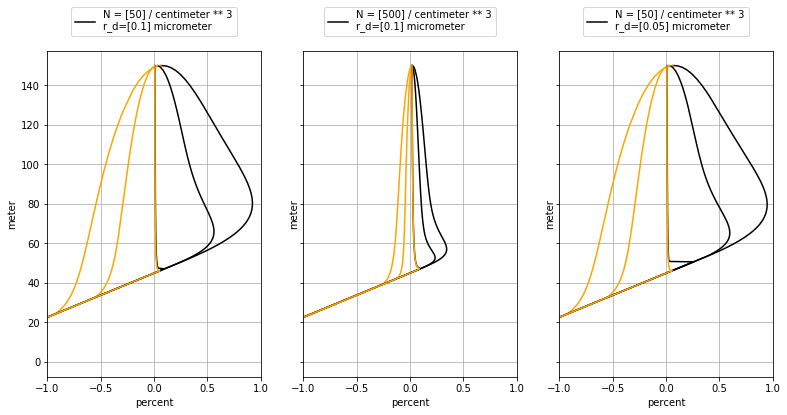

In [57]:
print("displacement vs. supersaturation")
fig, axs = plt.subplots(1, 3, figsize=figsize, sharey=True, sharex=True)
for i, lbl in enumerate(integ.keys()):
    first = True
    for ws in w_avg:
        axs[i].plot(S1[lbl][ws], h1[lbl][ws], label=lbl if first else '', color='k')
        axs[i].plot(S2[lbl][ws], h2[lbl][ws], color='orange')
        first = False
    axs[i].grid()
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))
    axs[i].xaxis.set_units(si.percent)
    axs[i].yaxis.set_units(si.metre)
    axs[i].set_xlim([-1, 1])


supersaturation vs. wet radius


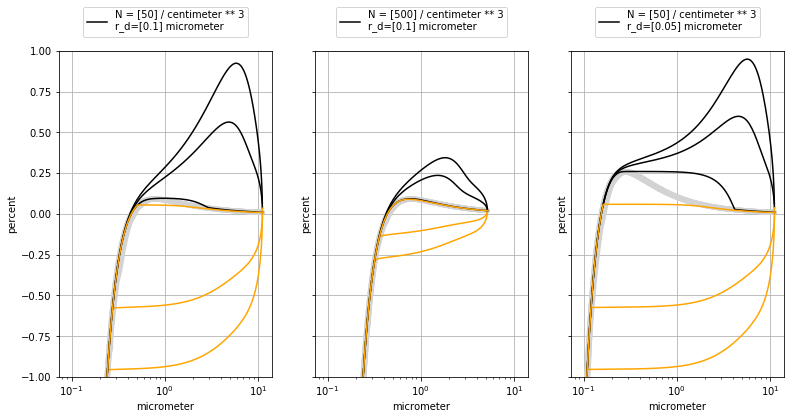

In [59]:
print("supersaturation vs. wet radius")
fig, axs = plt.subplots(1, 3, figsize=figsize, sharey=True, sharex=True)
for i, lbl in enumerate(integ.keys()):
    first = True
    axs[i].yaxis.set_units(si.dimensionless)
    for ws in w_avg:
        axs[i].plot(
            np.concatenate([r1[lbl][ws].magnitude, r2[lbl][ws].magnitude]) * r1[lbl][ws].units, 
            S_eq[lbl][ws], color='lightgray', linewidth=5
        )
    for ws in w_avg:
        axs[i].plot(r1[lbl][ws], S1[lbl][ws], label=lbl if first else '', color='k')
        axs[i].plot(r2[lbl][ws], S2[lbl][ws], color='orange')
        first = False
    axs[i].grid()
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))
    axs[i].set_ylim([-1, 1])
    axs[i].set_xscale('log')
    axs[i].yaxis.set_units(si.percent)
    axs[i].xaxis.set_units(si.micrometre)
    

displacement vs. wet radius


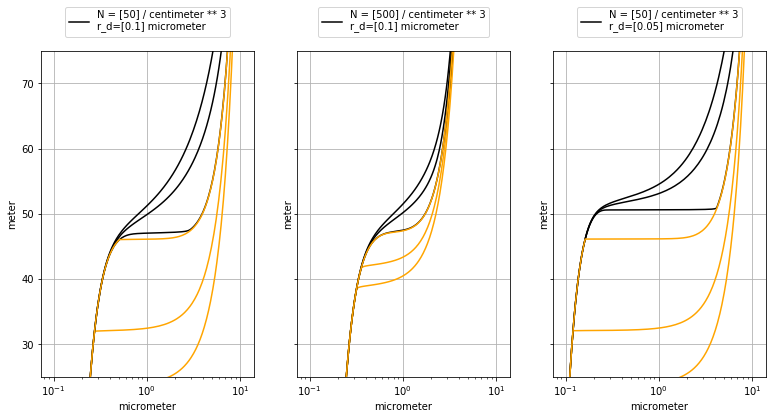

In [60]:
print("displacement vs. wet radius")
fig, axs = plt.subplots(1, 3, figsize=figsize, sharey=True, sharex=True)
for i, lbl in enumerate(integ.keys()):
    first = True
    for ws in w_avg:
        axs[i].plot(r1[lbl][ws], h1[lbl][ws], label=lbl if first else '', color='k')
        axs[i].plot(r2[lbl][ws], h2[lbl][ws], color='orange')
        first = False
    axs[i].grid()
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))
    axs[i].set_xscale('log')
    axs[i].xaxis.set_units(si.micrometre)
    axs[i].yaxis.set_units(si.metre)
    axs[i].set_ylim([25, 75])
